## Instructions
Using the Scikit-Learn framework, build a set of functioning binary classifiers using provided training data. Use comments to document your major steps (what and why) and any important decisions you make along the way. You can choose any performance metric(s) you like but please include AUC score as an output for the grader.

The data columns beginning with 'var' are numeric, and 'cat' are categorical. The target column is labeled 'target'.

Requirements
1. Build (3) Binary Classifiers using Logistic, Catboost, XGBoost algorithms. Pick the best & measure the metrics (accuracy, precision & recall, AUC score) using the provided training data. You may ensemble them if you wish. 
2. Modify the objective & evaluation functions of algorithm of choice to beat the **precision** of the model in the first requirement
3. Develop code to find a sample weighting scheme that produces better **precision** than the model in the second requirement
4. Document the key steps in your workflow (what and why)
5. Your code should be replicable so a grader can run your code and achieve the same results

In [1]:
import xgboost
import catboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc, precision_score
from catboost import CatBoostClassifier
import xgboost as xgb

print('xgboost version:', xgboost.__version__)
print('catboost version:', catboost.__version__)

xgboost version: 1.6.1
catboost version: 1.0.6


## Steps
1. Explore the data
    - Binary classification problem
    - 192 numerical features, 5 categorial features (20, 9, 3, 3, 3 numbers of classes)
    - No missing values
    - Dataset is imbalanced (far more 0 examples than 1 examples)
2. Build 3 basic models for baseline comparison
    - Logistic regression, XGBoost, and CatBoost
    - Initially address imbalanced nature of the dataset using `scale_pos_weight` parameter
    - Data preprocessing:
        - Logistic regression: one-hot encoding (included some code for PCA of numerical features to decrease model train time but did not end up using it)
        - XGBoost: one-hot encoding
        - CatBoost: little necessary because CatBoost can directly handle categorical variables
    - Modeling (set parameters, fit models, make predictions, evaluate predictions with AUC, Accuracy, F1 Score, and Precision)
3. Compare models: CatBoost performs the best by AUC metric, using basic class weighting to handle the imbalanced classes
    - Catboost model has a precision of `0.05053` and an AUC of `0.9251`.
4. To fulfill requirement No. 2, we modify the objective & evaluation functions to obtain higher precision with CatBoost
    - Objective function was set to `Logloss` and evaluation function was set to `Precision` to optimize for precision.
    - Modified model has an improved precision of `0.05176` and an AUC of `0.8815`.
5. To fulfill requirement No. 3, we adjust our sample weighting scheme.
    - Note: The more correct way to do this is to use a validation set (e.g. 60/20/20 train/validation/test set) to tune the hyperparameters, to avoid overfitting on the test set, but for now we stick with just our 80/20 train/test set.
    - Stratified test/train split
    - Set `scale_pos_weight` based on ratio of negative/positive examples in the training set.
    - New model has an improved precision of `0.05231` and an AUC of `0.8977`.

## Exploring the data

In [2]:
df = pd.read_csv('training_data.csv')
df.head()

,ID,var1,var2,var3,var4,var5,var6,var7,var8,var9,...,var189,var190,var191,var192,cat1,cat2,cat3,cat4,cat5,target
0,44686,86.52893,80.79771,75.25887,74.02016,69.01476,65.61648,63.23896,59.07834,56.80397,...,85.133333,84.45,85.20,85.900000,S,H,C,B,C,0
1,44687,68.56225,72.05599,69.52573,68.79211,65.48515,63.00976,61.19186,57.85757,55.94791,...,90.533333,86.55,87.24,87.300000,S,I,C,B,C,0
2,44688,77.88821,76.62270,73.11046,72.20956,68.26166,65.34046,63.19467,59.25676,57.01834,...,93.933333,90.20,89.84,88.600000,S,I,C,B,C,0
3,44689,81.11949,78.43038,74.59578,73.63714,69.45540,66.35951,64.07976,59.88543,57.50303,...,93.200000,88.15,88.48,87.766667,S,I,C,B,C,0
4,44690,62.18698,68.60618,67.86709,67.44987,65.15601,63.13671,61.52867,58.35072,56.42460,...,92.733333,88.15,88.00,88.566667,S,I,C,B,C,0


In [3]:
df.describe()

,ID,var1,var2,var3,var4,var5,var6,var7,var8,var9,...,var184,var185,var186,var187,var188,var189,var190,var191,var192,target
count,14193.000000,14193.000000,14193.000000,14193.000000,14193.000000,14193.000000,14193.000000,14193.000000,14193.000000,14193.000000,...,14193.000000,14193.000000,14193.000000,14193.000000,14193.000000,14193.000000,14193.000000,14193.000000,14193.000000,14193.000000
mean,60691.679067,49.770732,49.816368,49.842512,49.847619,49.866617,49.877695,49.883878,49.889778,49.889927,...,0.001097,0.001118,0.001011,63.757204,64.040851,64.371634,64.739135,65.117889,65.514350,0.009441
std,9537.840350,19.287088,13.258854,11.027864,10.617691,9.063626,8.015570,7.248920,5.796510,4.958480,...,0.002623,0.003166,0.003446,53.854362,52.536290,51.892179,51.490296,51.202395,51.035665,0.096710
min,44686.000000,1.962090,6.802490,10.049460,10.790220,14.121840,16.951820,19.406260,25.208090,29.421340,...,-0.006320,-0.007100,-0.007710,1.200000,1.200000,1.666667,2.050000,2.160000,2.066667,0.000000
25%,52284.000000,35.131290,40.745080,42.377800,42.688460,43.737880,44.455170,44.995210,46.016590,46.572020,...,-0.000530,-0.001050,-0.001430,21.400000,22.200000,22.533333,22.950000,22.880000,23.400000,0.000000
50%,60726.000000,49.798510,49.924220,50.051180,50.093620,50.080180,50.101920,50.063300,49.967990,49.864340,...,0.000860,0.000940,0.000890,49.600000,50.400000,50.866667,51.050000,51.400000,51.266667,0.000000
75%,69174.000000,64.213330,59.015310,57.290670,57.032030,55.972370,55.194490,54.661910,53.790120,53.208110,...,0.002220,0.002460,0.002620,90.200000,91.300000,92.066667,92.900000,93.760000,94.433333,0.000000
max,76811.000000,99.049230,94.186610,92.934460,92.637450,91.165920,89.667530,88.134180,83.558250,79.443060,...,0.012600,0.012890,0.012780,358.200000,323.700000,317.200000,306.600000,295.480000,291.200000,1.000000


In [4]:
df.target.value_counts()

0    14059
1      134
Name: target, dtype: int64

The mean of the target variable is very low, indicating that there are far more negative examples than positive ones.

In [5]:
df.dtypes

ID          int64
var1      float64
var2      float64
var3      float64
var4      float64
           ...   
cat2       object
cat3       object
cat4       object
cat5       object
target      int64
Length: 199, dtype: object

There are 192 numerical variables and 5 categorical variables.

In [6]:
df.isnull().sum()
df.isna().sum()

ID        0
var1      0
var2      0
var3      0
var4      0
         ..
cat2      0
cat3      0
cat4      0
cat5      0
target    0
Length: 199, dtype: int64

No missing values that have to be filled in or imputed.

In [7]:
df[['cat1','cat2','cat3','cat4','cat5','target']].nunique()

cat1      20
cat2       9
cat3       3
cat4       3
cat5       3
target     2
dtype: int64

Set seed to replicate modeling results

In [8]:
seed = 1234

---
## Logistic Regression

Logistic regression requires categorical variables to be label encoded or one-hot encoded. We can use dummy variables to one-hot encode the data.

In [9]:
data_d = pd.get_dummies(df, columns = ['cat1', 'cat2', 'cat3', 'cat4', 'cat5'], drop_first=True)
data_d = data_d.drop(columns = ['ID'])
data_d

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,...,cat2_F,cat2_G,cat2_H,cat2_I,cat3_B,cat3_C,cat4_B,cat4_C,cat5_B,cat5_C
0,86.52893,80.79771,75.25887,74.02016,69.01476,65.61648,63.23896,59.07834,56.80397,54.12610,...,0,0,1,0,0,1,1,0,0,1
1,68.56225,72.05599,69.52573,68.79211,65.48515,63.00976,61.19186,57.85757,55.94791,53.60131,...,0,0,0,1,0,1,1,0,0,1
2,77.88821,76.62270,73.11046,72.20956,68.26166,65.34046,63.19467,59.25676,57.01834,54.32896,...,0,0,0,1,0,1,1,0,0,1
3,81.11949,78.43038,74.59578,73.63714,69.45540,66.35951,64.07976,59.88543,57.50303,54.66082,...,0,0,0,1,0,1,1,0,0,1
4,62.18698,68.60618,67.86709,67.44987,65.15601,63.13671,61.52867,58.35072,56.42460,53.99952,...,0,0,0,1,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14188,47.96781,53.58394,54.47676,54.55176,54.55791,54.31886,54.03275,53.26412,52.66192,51.70551,...,0,1,0,0,0,0,1,0,1,0
14189,55.17972,56.97370,56.97717,56.90735,56.41071,55.87065,55.38196,54.26278,53.46933,52.29302,...,0,1,0,0,0,0,1,0,1,0
14190,49.10301,53.85240,54.66743,54.73619,54.73281,54.49331,54.20632,53.42876,52.81498,51.83753,...,0,0,1,0,0,0,1,0,1,0
14191,57.32696,57.47631,57.27852,57.18636,56.63372,56.07256,55.57220,54.43159,53.62302,52.42421,...,0,0,1,0,0,0,1,0,1,0


We employ an 80/20 train/test split, and then train the Logistic Regression model for the classification task. We calculate accuracy, F1, precision, and AUC metrics to evaluate the performance of the model on the testing data.

In [10]:
X1_train, X1_test, y1_train, y1_test = train_test_split(data_d, df['target'], test_size=0.2, random_state=0)

In [11]:
model1 = LogisticRegression(C=1.0)
model1.fit(X1_train, y1_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

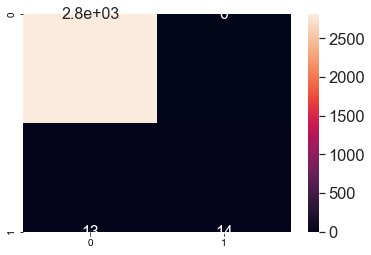

In [12]:
lr_predictions = model1.predict(X1_test)
lr_predictions

# Threshhold at 0.5
cm1 = confusion_matrix(y1_test, lr_predictions)

plt.figure(figsize = (6,4))
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
sns.set(font_scale=1.5)
sns.heatmap(cm1, annot=True, annot_kws={"size": 16}) 
plt.show()

In [13]:
accuracy_score(y1_test, lr_predictions)

0.995420922860162

In [14]:
f1_score(y1_test, lr_predictions)

0.6829268292682926

In [15]:
precision_score(y1_test, lr_predictions)

1.0

In [16]:
fpr, tpr, thresholds = roc_curve(y1_test, lr_predictions)
auc(fpr, tpr)

0.7592592592592593

---
#### Abandoned work: PCA

We can reduce the feature space using Principal Component Analysis to speed up training. 56 components account for 99% of the explained variance. Next steps would involve adding the categorical dummy variable columns and then training the logistic regression model.

In [17]:
data_var = df.drop(columns = ['ID','target','cat1','cat2','cat3','cat4','cat5'])

Xvar_train, Xvar_test, yvar_train, yvar_test = train_test_split(data_d, df['target'], test_size=0.2, random_state=0)

sc = StandardScaler()
Xvar_train = sc.fit_transform(Xvar_train)
Xvar_test = sc.transform(Xvar_test)

pca = PCA(n_components=56)
Xvar_train = pca.fit_transform(Xvar_train)
Xvar_test = pca.transform(Xvar_test)

explained_variance = pca.explained_variance_ratio_

sum = 0
for v in explained_variance:
    sum += v
    print(sum)

0.38220976615419583
0.5437813542116345
0.6370196284334056
0.6856434450454119
0.7238577500840554
0.748809956640483
0.7728156318891619
0.7883805381691743
0.8008817119981833
0.8115534090192006
0.8214936092291489
0.8308536294437744
0.839056340280254
0.845606575989954
0.8518104596981448
0.8575173405305849
0.8628173474774926
0.8680336922687768
0.8731752124591386
0.8782246951037527
0.8832510544714448
0.8881992582669596
0.893072639820471
0.8978447162966343
0.9025496108502612
0.9072101780145103
0.9118668668426915
0.9164227143193169
0.920931213570804
0.925427232698067
0.92987137200182
0.93423801325022
0.9385143292105492
0.942736445773841
0.9467989567012172
0.9507480031778933
0.9546552599288151
0.9582229515284469
0.9615141382660425
0.9643919538635477
0.9672095174798652
0.9697352718292895
0.9721235003253013
0.9741753560581954
0.9761871148841594
0.9779343860327943
0.9796632242817434
0.9811332047596085
0.9825804640632582
0.98392648546268
0.9851795363555754
0.9863890654288413
0.9875619236235331
0.988

---
## XGBoost

We can use the same one-hot encoded variables prepared for the logistic regression modeling.

In [18]:
X2 = data_d.drop(columns = ['target']).copy()
y2 = data_d['target']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=0)

print(X2_train.shape), print(y2_train.shape)
print(X2_test.shape), print(y2_test.shape)

(11354, 225)
(11354,)
(2839, 225)
(2839,)


(None, None)

In [19]:
params2 = {
    'max_depth': 3, 
    'eta': 0.01, 
    'silent': 0, 
    'eval_metric': 'auc',
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': seed,
    'scale_pos_weight': 105
}

train_matrix = xgb.DMatrix(X2_train, y2_train, feature_names=X2_train.columns.values)
test_matrix = xgb.DMatrix(X2_test, y2_test, feature_names=X2_test.columns.values)

evals = [(train_matrix,'train'),(test_matrix,'test')]
model2 = xgb.train(params = params2,
              dtrain = train_matrix,
              num_boost_round = 5000,
              verbose_eval=200, 
              early_stopping_rounds = 500,
              evals=evals,
              maximize = True)

[11:56:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.92243	test-auc:0.87831
[200]	train-auc:0.96742	test-auc:0.91472
[400]	train-auc:0.98552	test-auc:0.91622
[538]	train-auc:0.99174	test-auc:0.91477


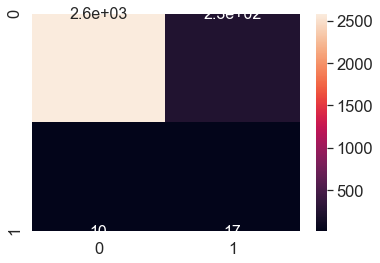

In [20]:
xgb_predictions = model2.predict(test_matrix)
xgb_predictions

# Threshhold at 0.5
cm2 = confusion_matrix(y2_test, [1 if p > 0.5 else 0 for p in xgb_predictions])

plt.figure(figsize = (6,4))
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
sns.set(font_scale=1.5)
sns.heatmap(cm2, annot=True, annot_kws={"size": 16}) 
plt.show()

In [21]:
accuracy_score(y2_test, [1 if p > 0.5 else 0 for p in xgb_predictions])

0.9144064811553364

In [22]:
f1_score(y2_test, [1 if p > 0.5 else 0 for p in xgb_predictions])

0.12274368231046934

In [23]:
precision_score(y2_test, [1 if p > 0.5 else 0 for p in xgb_predictions])

0.068

---
## CatBoost

There is no need to one-hot encode the categorical variables due to the native support for categorical variables in CatBoost.

In [24]:
X3 = df.drop(columns = ['target', 'ID']).copy()
y3 = df['target']

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=0)

print(X3_train.shape), print(y3_train.shape)
print(X3_test.shape), print(y3_test.shape)

(11354, 197)
(11354,)
(2839, 197)
(2839,)


(None, None)

In [25]:
params3 = {
    'iterations': 5000,
    'learning_rate': 0.01,
    'cat_features': ['cat1','cat2','cat3','cat4','cat5'],
    'depth': 3,
    'eval_metric': 'AUC',
    'verbose': 200,
    'od_type': 'Iter',
    'od_wait': 50,
    'random_seed': seed,
    'scale_pos_weight': 105
}

model3 = CatBoostClassifier(**params3)

In [26]:
model3.fit(X3_train, y3_train, eval_set=(X3_test, y3_test), use_best_model=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.9026131	best: 0.9026131 (0)	total: 229ms	remaining: 19m 3s
200:	test: 0.9241215	best: 0.9251225 (162)	total: 8.91s	remaining: 3m 32s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9251224909
bestIteration = 162

Shrink model to first 163 iterations.


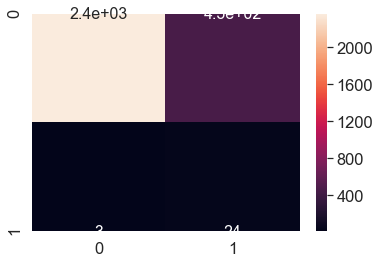

In [27]:
cat_predictions = model3.predict(X3_test)
cat_predictions

# Threshhold at 0.5
cm3 = confusion_matrix(y3_test, [1 if p > 0.5 else 0 for p in cat_predictions])

plt.figure(figsize = (6,4))
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
sns.set(font_scale=1.5)
sns.heatmap(cm3, annot=True, annot_kws={"size": 16}) 
plt.show()

In [28]:
accuracy_score(y3_test, cat_predictions)

0.8400845368087355

In [29]:
f1_score(y3_test, cat_predictions)

0.09561752988047809

In [30]:
precision_score(y3_test, cat_predictions)

0.05052631578947368

In [31]:
features = [f for f in list(X3)]
feature_importance = [x for x in zip(X3.columns, model3.get_feature_importance())]
fi_df = pd.DataFrame(feature_importance, columns=['Feature', 'VarImp'])
fi_df = fi_df.sort_values('VarImp', ascending=False)
fi_df[fi_df['VarImp'] > 0]

,Feature,VarImp
0,var1,12.122581
3,var4,9.784977
1,var2,7.494626
2,var3,7.376486
4,var5,5.408584
...,...,...
171,var172,0.000680
20,var21,0.000586
196,cat5,0.000187
67,var68,0.000168


## Comparing the 3 models

We select the CatBoost model for parameter tuning and objective function/eval metric selection because it has the highest AUC.

In [32]:
# Model 1 AUC
fpr, tpr, thresholds = roc_curve(y1_test, lr_predictions)
auc(fpr, tpr)

0.7592592592592593

In [33]:
# Model 2 AUC
model2.best_score

0.9248393129972078

In [34]:
# Model 3 AUC
model3.best_score_

{'learn': {'Logloss': 0.26101895028740907},
 'validation': {'Logloss': 0.33934189401923587, 'AUC': 0.9251224909119646}}

## CatBoost: Modifying Objective Function & Evaluation Metric

We can use the same train/test datasets as the CatBoost model in the previous step.

In order to improve the precision of the CatBoost model, we set the evaluation metric to precision, instead of AUC.

In [35]:
params4 = {
    'iterations': 5000,
    'learning_rate': 0.01,
    'cat_features': ['cat1','cat2','cat3','cat4','cat5'],
    'depth': 3,
    'loss_function': 'Logloss',
    'eval_metric': 'Precision',
    'verbose': 200,
    'od_type': 'Iter',
    'od_wait': 50,
    'random_seed': seed,
    'scale_pos_weight': 105
}

model4 = CatBoostClassifier(**params4)

In [36]:
model4.fit(X3_train, y3_train, eval_set=(X3_test, y3_test), use_best_model=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8155340	test: 0.8185907	best: 0.8185907 (0)	total: 48.3ms	remaining: 4m 1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8514433993
bestIteration = 92

Shrink model to first 93 iterations.


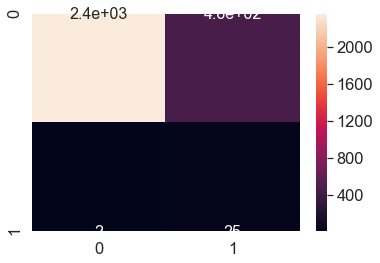

In [37]:
cat_predictions = model4.predict(X3_test)
cat_predictions

# Threshhold at 0.5
cm4 = confusion_matrix(y3_test, [1 if p > 0.5 else 0 for p in cat_predictions])

plt.figure(figsize = (6,4))
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
sns.set(font_scale=1.5)
sns.heatmap(cm4, annot=True, annot_kws={"size": 16}) 
plt.show()

In [38]:
accuracy_score(y3_test, cat_predictions)

0.8379711165903487

In [39]:
f1_score(y3_test, cat_predictions)

0.09803921568627451

In [40]:
precision_score(y3_test, cat_predictions)

0.051759834368530024

The precision of the new model is **0.05176**, which exceeds the precision of the original CatBoost model of **0.05053**. However, the new model's AUC is worse.

In [41]:
# model 4 AUC
fpr, tpr, thresholds = roc_curve(y3_test, cat_predictions)
auc(fpr, tpr)

0.8815262631052105

In [42]:
# model 3 AUC
model3.best_score_

{'learn': {'Logloss': 0.26101895028740907},
 'validation': {'Logloss': 0.33934189401923587, 'AUC': 0.9251224909119646}}

## CatBoost: Sample Weight Scheme

We can improve the precision of CatBoost even further by employing a better sample weighting scheme. We can set the `scale_pos_weight` parameter to the actual ratio of negative and positive examples in the training set.

In [43]:
X5 = df.drop(columns = ['target', 'ID']).copy()
y5 = df['target']

X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.2, random_state=0, stratify=y5)

print(X5_train.shape), print(y5_train.shape)
print(X5_test.shape), print(y5_test.shape)

(11354, 197)
(11354,)
(2839, 197)
(2839,)


(None, None)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185226	test: 0.8036579	best: 0.8036579 (0)	total: 47.8ms	remaining: 3m 58s
200:	learn: 0.8488015	test: 0.8401434	best: 0.8401434 (197)	total: 7.69s	remaining: 3m 3s
400:	learn: 0.8640859	test: 0.8502008	best: 0.8529924 (370)	total: 14.5s	remaining: 2m 45s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8529923985
bestIteration = 370

Shrink model to first 371 iterations.


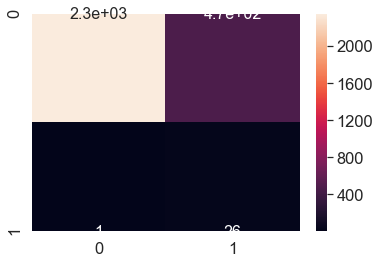

scale_pos_weight: 105.11214953271028, Accuracy: 0.8337, F1: 0.09924, Precision: 0.05231, AUC: 0.8977



In [44]:
w = y5_train.value_counts()[0] / y5_train.value_counts()[1]

params5 = {
    'iterations': 5000,
    'learning_rate': 0.01,
    'cat_features': ['cat1','cat2','cat3','cat4','cat5'],
    'depth': 3,
    'loss_function': 'Logloss',
    'eval_metric': 'Precision',
    'verbose': 200,
    'od_type': 'Iter',
    'od_wait': 50,
    'random_seed': seed,
    'scale_pos_weight': w
}

model5 = CatBoostClassifier(**params5)
model5.fit(X5_train, y5_train, eval_set=(X5_test, y5_test), use_best_model=True, plot=True)
cat_predictions = model5.predict(X5_test)

cm5 = confusion_matrix(y5_test, [1 if p > 0.5 else 0 for p in cat_predictions])
plt.figure(figsize = (6,4))
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
sns.set(font_scale=1.5)
sns.heatmap(cm5, annot=True, annot_kws={"size": 16}) 
plt.show()

a = accuracy_score(y5_test, cat_predictions)
f = f1_score(y5_test, cat_predictions)
p = precision_score(y5_test, cat_predictions)
fpr, tpr, thresholds = roc_curve(y5_test, cat_predictions)
aupr = auc(fpr, tpr)
print(f'scale_pos_weight: {w}, Accuracy: {a:.4f}, F1: {f:.5f}, Precision: {p:.5f}, AUC: {aupr:.4f}\n')